In [1]:
#dependancies from last exercise sheet

def PlotContourLine(func, value=0, minx=0, maxx=10, miny=0, maxy=10):
    #This plots the contourline func(x) = value
    
    samplenum = 1000
    xrange = np.arange(minx, maxx, (maxx-minx)/samplenum)
    yrange = np.arange(miny, maxy, (maxy-miny)/samplenum)
    
    #This generates a two-dimensional mesh
    X, Y = np.meshgrid(xrange,yrange)
    
    argsForf = np.array([X.flatten(),Y.flatten()]).T
    Z = func(argsForf)
    Z = np.reshape(Z,X.shape)
    
    plt.xlim(minx, maxx)
    plt.ylim(miny, maxy)
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    #plt.contour(X, Y, Z, alpha=0.5,levels=[value],linestyles='dashed',linewidths=3)
    Z = np.where(Z > value, 1, -1)
    plt.contourf(X, Y, Z, alpha=0.2, colors=('red', 'blue'))
    
def compute_confusion_matrix(f, x, y, n):
    c = np.empty((n,n))
    y_predicted = np.sign(f(x))
    for i in range(0, n):
        for j in range(0, n):
            c[i,j] = np.sum(np.logical_and(y_predicted == i, y == j))
    return c

import numpy.linalg as LA
#this function solves the linear least squares problem using a qr factorization.
#If x and y are nxk and nx1 arrays then alpha is an 
def lls(x,y):
    X_hat = np.hstack((np.ones((x.shape[0],1)), x))
    b = np.dot(X_hat.T, y)
    q, r = LA.qr(np.dot(X_hat.T, X_hat))
    p = np.dot(q.T, b)
    alpha = np.dot(LA.inv(r), p)
    #return a function that applies alpha
    return (lambda t: np.dot(np.hstack((np.ones((t.shape[0],1)), t)), alpha))

In [45]:
import numpy as np


#this class wraps our classifier function f and it 
#provides a a member method to perform the OneStep function 
#on our parameters beta and b.
class Classifier:
    def __init__(self, x, y, C, kernel = np.dot):
        self.x = x
        self.y = y
        self.C = C
        self.kernel = kernel
        self.beta = np.zeros(y.size)
        self.b = .0
        self.b_old = .0
        self.fx = np.zeros(y.size)

    def OneStep(self, i, j):
        beta_i_old = self.beta[i]
        beta_j_old = self.beta[j]
        delta = self.y[i]*((self.fx[j]-self.y[j])-(self.fx[i]-self.y[i]))
        s = self.y[i]*self.y[j]
        chi = self.kernel(self.x[i], self.x[i].T) \
            +self.kernel(self.x[j], self.x[j].T) \
            -2*self.kernel(self.x[i], self.x[j].T)
        gamma = s*self.beta[i]+self.beta[j]
        
        if s == 1:
            L = max(0,gamma-self.C)
            H = min(gamma, self.C)
        else:
            L = max(0,-gamma)
            H = min(self.C,self.C-gamma)
        
        if chi>0:
            self.beta[i] = min(max(self.beta[i]+delta/chi,L),H)
        elif delta>0:
            self.beta[i] = L
        else:
            self.beta[i] = H
        
        self.beta[j] = gamma-s*self.beta[i]
        self.fx += ((self.beta[i]-beta_i_old)*self.y[i]*self.kernel(self.x, self.x[i].T)).reshape(-1)\
            + ((self.beta[j]-beta_j_old)*self.y[j]*self.kernel(self.x, self.x[j].T)).reshape(-1)\
            + self.b - self.b_old
        self.b_old = self.b
        self.b = self.b - 0.5*(self.fx[i]-self.y[i]+self.fx[j]-self.y[j])
        
    def update_bias_to_median(self):
        self.b = self.b - np.median((self.fx - self.y)[self.beta > 0])       
       
    def predict(self, t):
        return np.dot((self.beta*self.y).T, self.kernel(self.x,t.T)) + self.b
    
    def KKT(self):        
        return (self.C-self.beta)*np.maximum(0, 1-self.y*self.fx)+self.beta*np.maximum(0, self.y*self.fx-1)

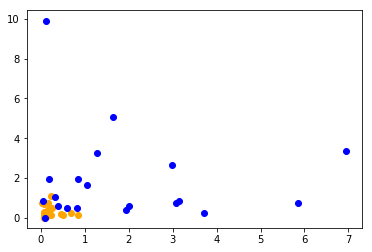

In [40]:
import matplotlib.pyplot as plt

x = np.append(np.random.exponential(0.25, (20,2)),np.random.exponential(2, (20,2)),0)
y = np.append(-np.ones(20),np.ones(20))
plt.scatter(x[:20,0],x[:20,1],c='orange')
plt.scatter(x[20:,0],x[20:,1],c='blue')
              
plt.show()


There are 38 support vector and 2 margin vectors


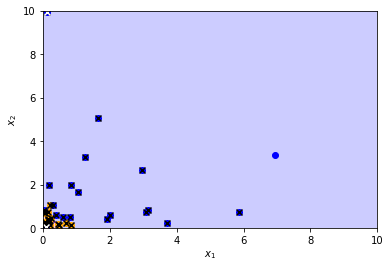

There are 16 support vector and 3 margin vectors


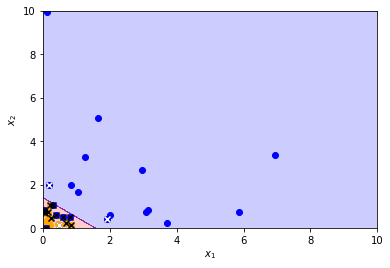

There are 13 support vector and 4 margin vectors


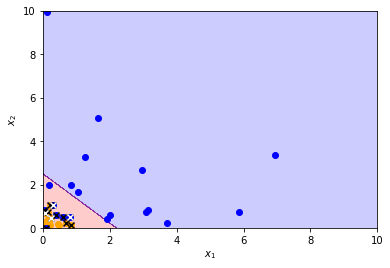

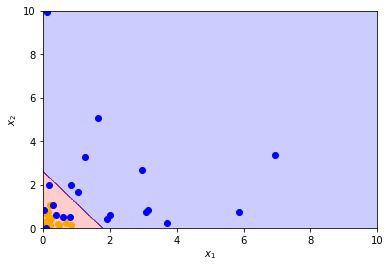

In [42]:
import random # random.sample is much faster than np.random.choice for k << n

def SMO(clf):
    for i in range(10000):
        idx1, idx2 = random.sample(range(y.size), 2)
        clf.OneStep(idx1, idx2)
    clf.update_bias_to_median()

clfs = []
for c in [0.01, 1, 100]:
    clf = Classifier(x, y, c)
    SMO(clf)
    sv = x[clf.beta > 0]
    mv = x[(c > clf.beta) & (clf.beta > 0)]
    print("There are {} support vector and {} margin vectors".format(sv.shape[0],mv.shape[0]))
    PlotContourLine(clf.predict)
    plt.scatter(x[:20,0],x[:20,1], c='orange')
    plt.scatter(x[20:,0],x[20:,1],c='blue')
    plt.scatter(sv[:,0],sv[:,1], c='black', marker='x')
    plt.scatter(mv[:,0],mv[:,1], c='white', marker='x')
    plt.show()
    clfs.append(clf)

lls_predict = lls(x,y)
PlotContourLine(lls_predict)
plt.scatter(x[:20,0],x[:20,1], c='orange')
plt.scatter(x[20:,0],x[20:,1],c='blue')
plt.show()
    

For 10000 iterations the results are very unreliable. Tipically the best results are obtained for c = 1. The hyperplane computed by lls does not optimally seperate the two classes, as the variance of input points belonging to the second class is much bigger than the variance of points belonging to the first class. This pulls the seperating hyperplane more to the second class.

In [20]:
x_test = np.append(np.random.exponential(0.25, (1000,2)),np.random.exponential(2, (1000,2)),0)
y_test = np.append(-np.ones(1000),np.ones(1000))

for clf, c in zip(clfs, [0.01, 1, 100]):
    m = compute_confusion_matrix(clf.predict, x_test, y_test, 2)
    print("The accurcy of our svm for c={} is {}".format(c, np.trace(m)/2000))
m = compute_confusion_matrix(lls_predict, x_test, y_test, 2)
print("The accurcy of th lls is {}".format(np.trace(m)/2000))

The accurcy of our svm for c=0.01 is 0.115
The accurcy of our svm for c=1 is 0.422
The accurcy of our svm for c=100 is 0.5
The accurcy of th lls is 0.3265


After 75 iterations, all kkt conditions are zero.
There are 38 support vector and 2 margin vectors


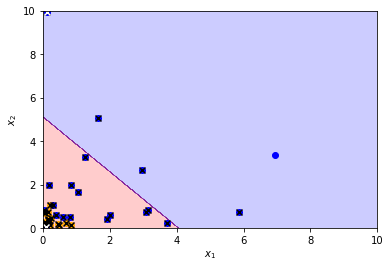

After 1108 iterations, all kkt conditions are zero.
There are 16 support vector and 3 margin vectors


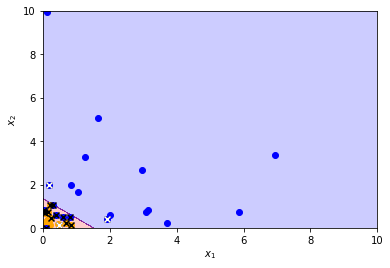

There are 13 support vector and 3 margin vectors


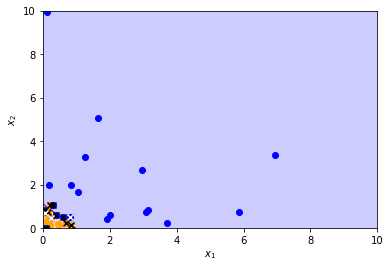

In [44]:
def SMO_KKT(clf):
    for it in range(10000): 
        kkt = clf.KKT()
        i = np.argmax(kkt)
        if(kkt[i] == 0):
            print("After {} iterations, all kkt conditions are zero.".format(it))
            clf.update_bias_to_median()
            return
        mv = (clf.beta > 0) & (clf.C > clf.beta)
        mv[i] = 0
        if(np.sum(mv) > 0):
            j = np.random.choice(np.arange(kkt.shape[0]), 1, p = mv/np.sum(mv))
        else:
            n_i = np.arange(kkt.shape[0]) != i
            j = np.random.choice(np.arange(kkt.shape[0]), 1, p = n_i/np.sum(n_i))
        clf.OneStep(i,j)
    clf.update_bias_to_median()

clfs = []
for c in [0.01, 1, 100]:
    clf = Classifier(x, y, c)
    SMO_KKT(clf)
    sv = x[clf.beta > 0]
    mv = x[(c > clf.beta) & (clf.beta > 0)]
    print("There are {} support vector and {} margin vectors".format(sv.shape[0],mv.shape[0]))
    PlotContourLine(clf.predict)
    plt.scatter(x[:20,0],x[:20,1], c='orange')
    plt.scatter(x[20:,0],x[20:,1],c='blue')
    plt.scatter(sv[:,0],sv[:,1], c='black', marker='x')
    plt.scatter(mv[:,0],mv[:,1], c='white', marker='x')
    plt.show()
    clfs.append(clf)

For c=0.001 and c = 1 using the heuristic is significantly faster.

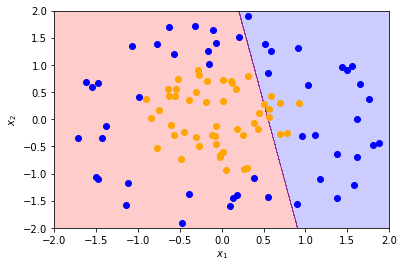

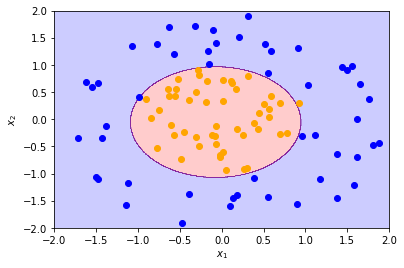

In [46]:
from sklearn.preprocessing import normalize

b= np.random.multivariate_normal(np.zeros(2), np.eye(2), 1000) 
u = np.power(np.random.rand(1000)*4, 0.5)
b = normalize(b) * u.reshape(u.size,1)
norms = np.linalg.norm(b, axis = 1)
x = np.append(b[norms < 1][:50], b[norms > 1][:50], axis = 0)
y = np.append(-np.ones(50), np.ones(50))


clf = Classifier(x,y,10)
SMO_KKT(clf)
PlotContourLine(clf.predict,0, -2, 2, -2, 2)
plt.scatter(x[:50,0],x[:50,1],c='orange')
plt.scatter(x[50:,0],x[50:,1],c='blue')
plt.show()

def phi(x):
    return np.append(x, np.power(np.linalg.norm(x, axis = 1), 2).reshape(x.shape[0],1), axis = 1)
    
clf = Classifier(phi(x),y,10)
SMO_KKT(clf)
PlotContourLine(lambda x: clf.predict(phi(x)),0, -2, 2, -2, 2)
plt.scatter(x[:50,0],x[:50,1],c='orange')
plt.scatter(x[50:,0],x[50:,1],c='blue')

plt.show()

The SVM seperates the two classes along the third feature(i.e. the norm squared) since this
is exactly the feature defining the two classes.

In [49]:
from numpy.matlib import repmat

def gaussian_kernel(x,y):
    if(x.ndim == 1): x.shape = (1,-1)
    if(y.ndim == 1): y.shape = (1,-1)
    diff = (repmat(x,1,y.shape[0])-y.reshape(-1)).reshape(-1,2)
    return np.exp(-np.linalg.norm(diff, axis = 1).reshape(x.shape[0],y.shape[0])/2)

clf = Classifier(x,y,10, gaussian_kernel)
SMO_KKT(clf)
PlotContourLine(lambda x: clf.predict(x),0, -2, 2, -2, 2)
plt.scatter(x[:50,0],x[:50,1],c='orange')
plt.scatter(x[50:,0],x[50:,1],c='blue')


ValueError: operands could not be broadcast together with shapes (1,4) (2,) 

In [24]:
#Load MNIST Data
import os
import gzip
from urllib.request import urlretrieve

#load SVC and GridSearchCV for crossvalidation
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix


def download (filename , source ='http://yann.lecun.com/exdb/mnist/'):
    print (" Downloading %s" % filename )
    urlretrieve ( source + filename , filename )


def load_mnist_images ( filename ):
    if not os.path. exists ( filename ):
        download ( filename )
    with gzip.open(filename , 'rb') as f:
        data = np. frombuffer (f.read () , np.uint8 , offset=16)
    data = data. reshape (-1, 28, 28)
    return data / np. float32 (256)

def load_mnist_labels ( filename ):
    if not os.path. exists ( filename ):
        download ( filename )
    with gzip.open(filename , 'rb') as f:
        data = np. frombuffer (f.read () , np.uint8 , offset=8)
    return data

X_train = load_mnist_images ('train-images-idx3-ubyte.gz')
y_train = load_mnist_labels ('train-labels-idx1-ubyte.gz')
X_test = load_mnist_images ('t10k-images-idx3-ubyte.gz')
y_test = load_mnist_labels ('t10k-labels-idx1-ubyte.gz')


parameters = {'gamma':[.1, .01, .001], 'C':[1, 10, 100]}

cv = GridSearchCV(svm.SVC(), parameters, cv = 5)
indices = np.random.choice(np.arange(0,y_train.size), 500, False)
cv.fit(X_train[indices].reshape(indices.size, -1), y_train[indices])

indices = np.random.choice(np.arange(0,y_train.size), 2000, False)
clf = cv.best_estimator_
clf.fit(X_train[indices].reshape(indices.size, -1), y_train[indices])

c = confusion_matrix(clf.predict(X_test.reshape(X_test.shape[0], -1)), y_test)

print(c.trace()/y_test.size)



0.9376
